# Focal Plane Distortion Analysis

In [1]:
%matplotlib inline

In [2]:
import datetime
import os
import pathlib

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
import matplotlib.dates

In [5]:
import numpy.polynomial

In [6]:
import scipy.optimize

In [7]:
import pandas as pd

In [8]:
import desimeter.transform.pos2ptl
import desimeter.transform.xy2qs

In [9]:
# Waiting for https://github.com/desihub/desiconda/issues/52 until this runs in a desiconda env
import fpoffline.io
import fpoffline.array
from fpoffline.scripts.endofnight import ptl2fp_nominal

In [13]:
NERSC = False

In [14]:
SCRATCH = pathlib.Path(os.getenv('SCRATCH')) if NERSC else pathlib.Path('/Users/dkirkby/Downloads')
assert SCRATCH.exists()

Read a single end-of-night file to lookup some static data:

In [17]:
kwargs = dict(verbose=False)
if not NERSC:
    kwargs['parent_dir'] = SCRATCH
S, M = fpoffline.io.load_endofnight(20220101, **kwargs)

Build dictionaries to map between pos_id and location:

In [18]:
pos2loc = {row['DEVICE_ID']: row['LOCATION'] for row in S}
loc2pos = {row['LOCATION']: row['DEVICE_ID'] for row in S}

Look up the offset_x,y and r1,r2 calibration params for each robot, which are in "flat" space:

In [20]:
def get_calib_by_loc():
    offsets_by_loc = np.zeros((9600, 2))
    r12s_by_loc = np.zeros((9600, 3))
    for row in S.filled():
        # Lookup the calibration offset params, which are in "flat" space.
        x_flat, y_flat = row['OFFSET_X'], row['OFFSET_Y']
        # Convert from flat to petal space.
        x_ptl, y_ptl = desimeter.transform.pos2ptl.flat2ptl(x_flat, y_flat)
        # Rotate to FP space with nominal petal alignment.
        loc = row['LOCATION']
        x_fp, y_fp = ptl2fp_nominal(np.array([x_ptl]), np.array([y_ptl]), np.array([loc // 1000]))
        # Lookup the arm lengths.
        r1, r2 = row['LENGTH_R1'], row['LENGTH_R2']
        # Lookup the conversion from r (PTL) to s (FLAT).
        r = np.hypot(x_ptl, y_ptl)
        dr = 0.1
        if r < 420:
            ds = desimeter.transform.xy2qs.r2s(r + dr / 2) - desimeter.transform.xy2qs.r2s(r - dr / 2)
        else:
            ds = 1.
        # Save by location.
        offsets_by_loc[loc] = x_fp[0], y_fp[0]
        r12s_by_loc[loc] = r1, r2, ds / dr
    return offsets_by_loc, r12s_by_loc

offsets_by_loc, r12s_by_loc = get_calib_by_loc()

In [37]:
def nightrange(first, last):
    """Loop over nights YYYYMMDD in [first, last]."""
    one_day = datetime.timedelta(days=1)
    begin, end = [datetime.datetime.strptime(str(night), "%Y%m%d") for night in (first, last)]
    date = begin
    while date <= end:
        yield int(date.strftime("%Y%m%d"))
        date += one_day

In [38]:
def load_nights(start, stop):
    moves = [ ]
    for night in nightrange(start, stop):
        try:
            S, M = fpoffline.io.load_endofnight(night, verbose=False)
            # Keep only non-blocked blind moves for enabled robots.
            sel = M.req_x.notna() & M.obs_x.notna() & (M.exposure_iter == 0) & M.ctrl_enabled & ~M.blocked
            # Keep only selected columns to save space.
            M = pd.DataFrame(M[sel][['location','ptl_x','ptl_y','req_x','req_y']])
            # Replace the measured (x,y) with the residuals (dx,dy).
            M['dx'] = 1e3 * (M.ptl_x - M.req_x)
            M['dy'] = 1e3 * (M.ptl_y - M.req_y)
            M = M.drop(columns=['ptl_x', 'ptl_y'])
            # Subtract the nominal robot centers from the requested (x,y).
            offsets = offsets_by_loc[M.location]
            M['req_x'] -= offsets[:,0]
            M['req_y'] -= offsets[:,1]
            moves.append(M)
            print(f'Loaded {len(moves[-1])} moves for {night}')
        except Exception as e:
            #raise e
            print(f'Unable to read {night}')
    return pd.concat(moves, axis='index', ignore_index=True)

`load_nights` takes ~14 mins to run, so save the results to a feather file using the next 2 lines, then
comment them out and just use the third line to read them. You will need to `conda install pyarrow` in your environment for feather support.

In [39]:
#%time All = load_nights(start=20211101, stop=20220613)

In [18]:
#All.to_feather(SCRATCH / 'All.feather')

In [21]:
All = pd.read_feather(SCRATCH / 'All.feather')

In [22]:
nrobots = len(np.unique(All.location))
print(f'Loaded {len(All)} moves for {nrobots} robots (avg {len(All) / nrobots:.1f} moves/robot)')

Loaded 21482855 moves for 4288 robots (avg 5010.0 moves/robot)


Plot the median residuals for each robot.  These should mostly be due to solid-body misalignments (offset and rotation) of each petal:

In [23]:
def quiverFP(locs, dx, dy, ref=100, size=10, color='k', ax=None):
    FP = fpoffline.array.DeviceArray()
    x, y = FP.xy(locs)
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(size, size))
        ax.axis('off')
        ax.set_xlim(-420, 420)
        ax.set_ylim(-420, 420)
        ax.set_aspect(1)
    Q = ax.quiver(x, y, dx, dy, angles='xy', scale=ref/50, scale_units='xy',
                  headwidth=5, headlength=6, width=0.001, color=color)
    ax.quiverkey(Q, X=0.9, Y=0.9, U=ref, label=f'{ref}μm', labelpos='S')
    return ax

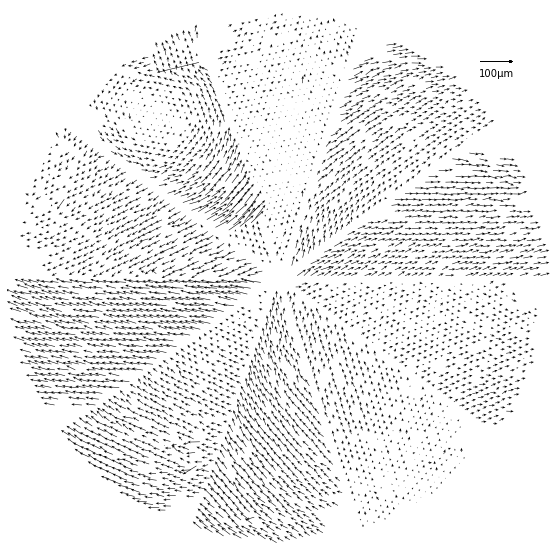

In [24]:
def plot_all(M, median=True):

    # Calculate median obs-req residuals per device.
    bypos = M.groupby(by='location')
    if median:
        avg = bypos.median()
    else:
        avg = bypos.mean()

    locs = np.array(avg.index, int)
    dx, dy = np.array(avg.dx), np.array(avg.dy)
    ax = quiverFP(locs, dx, dy, ref=100)
    
plot_all(All)

Fit for 5 rigid-body parameters per petal to correct for any misalignments:

In [25]:
def get_outliers(x, nsig=4):
    # Calculate the median and median-absolute deviation (MAD)
    med = np.median(x)
    MAD = np.median(np.abs(x - med))
    # Estimate the equivalent Gaussian sigma
    sigma = 1.4826 * MAD
    # Cut to identify outliers.
    outlier_cut = med + nsig * sigma
    return x >= outlier_cut

In [385]:
def fit_petals(M, outlier_nsig=4):
    
    def model_full(params, x, y):
        offset_x, offset_y, rot_x, rot_y, rot_phi = params
        C, S = np.cos(rot_phi), np.sin(rot_phi)
        pred_dx = 1e3 * (rot_x + C * (x - rot_x) - S * (y - rot_y) - x) + offset_x
        pred_dy = 1e3 * (rot_y + S * (x - rot_x) + C * (y - rot_y) - y) + offset_y
        return pred_dx, pred_dy

    def model_rotation(params, x, y):
        rot_x, rot_y, rot_phi = params
        C, S = np.cos(rot_phi), np.sin(rot_phi)
        pred_dx = 1e3 * (rot_x + C * (x - rot_x) - S * (y - rot_y) - x)
        pred_dy = 1e3 * (rot_y + S * (x - rot_x) + C * (y - rot_y) - y)
        return pred_dx, pred_dy

    def model_offset(params, x, y):
        offset_x, offset_y = params
        pred_dx = offset_x * np.ones_like(x)
        pred_dy = offset_y * np.ones_like(y)
        return pred_dx, pred_dy

    def chisq(params, x, y, dx, dy, model):
        pred_dx, pred_dy = model(params, x, y)
        return np.sum((dx - pred_dx) ** 2) + np.sum((dy - pred_dy) ** 2)
    
    params = [ ]
    bypos = M.groupby(by='location')
    avg = bypos.median()
    for petal_loc in range(10):    
        sel = avg.index // 1000 == petal_loc
        petal = avg[sel]
        locs = np.array(petal.index, int)
        offsets = offsets_by_loc[locs]
        x = offsets[:,0]
        y = offsets[:,1]
        dx = np.array(petal.dx)
        dy = np.array(petal.dy)
        
        # do an initial 2-param fit to the offsets only.
        initial = [ 0., 0., x.mean(), y.mean(), 0. ]
        fit_offset = scipy.optimize.minimize(chisq, initial[:2], args=(x, y, dx, dy, model_offset), method='Nelder-Mead')
        assert fit_offset.success

        # fit the full 5-param model using initial offsets from the 2-param fit.
        initial[:2] = fit_offset.x
        fit_full = scipy.optimize.minimize(chisq, initial, args=(x, y, dx, dy, model_full), method='Nelder-Mead')
        assert fit_full.success
        
        # identify "core" robots whose fit residuals are not outliers.
        fit_dx, fit_dy = model_full(fit_full.x, x, y)
        residual = np.hypot(dx - fit_dx, dy - fit_dy)
        core = ~get_outliers(residual, outlier_nsig)
        
        # refine the 5-param model with outliers removed.
        initial[:] = fit_full.x
        fit_full_core = scipy.optimize.minimize(
            chisq, initial, args=(x[core], y[core], dx[core], dy[core], model_full), method='Nelder-Mead')
        assert fit_full_core.success

        # Calculate the best-fit model for all (core + outlier) robots.
        fit_dx, fit_dy = model_full(fit_full_core.x, x, y)
        
        # Save the best-fit model and residuals for all robots.
        avg.loc[sel, 'fit_dx'] = fit_dx
        avg.loc[sel, 'fit_dy'] = fit_dy
        avg.loc[sel, 'resid_dx'] = dx - fit_dx
        avg.loc[sel, 'resid_dy'] = dy - fit_dy
        avg.loc[sel, 'core'] = core
        params.append(fit_full_core.x)
        
    return avg, np.array(params)

fit_results, fit_params = fit_petals(All, outlier_nsig=2.5)

In [28]:
def plot_fit(fit_results, fit_params, what='model', centers=False, ref=100, save=None):

    locs = np.array(fit_results.index, int)
    petal_locs = locs // 1000
    core = np.array(fit_results.core, bool)
    if what == 'model':
        dx, dy = np.array(fit_results.fit_dx), np.array(fit_results.fit_dy)
    elif what == 'offset':
        dx, dy = fit_params[petal_locs, :2].T
    elif what == 'rotate':
        rot_x, rot_y = fit_params[petal_locs, 2:4].T
        C, S = np.cos(fit_params[:,4]), np.sin(fit_params[:,4])
        offsets = offsets_by_loc[locs]
        x = offsets[:,0]
        y = offsets[:,1]        
        dx = 1e3 * (rot_x + C[petal_locs] * (x - rot_x) - S[petal_locs] * (y - rot_y) - x)
        dy = 1e3 * (rot_y + S[petal_locs] * (x - rot_x) + C[petal_locs] * (y - rot_y) - y)
    elif what == 'residuals':
        dx, dy = np.array(fit_results.resid_dx), np.array(fit_results.resid_dy)
    elif what == 'data':
        dx, dy = np.array(fit_results.dx), np.array(fit_results.dy)
    else:
        print(f'Invalid what: "{what}".  Expected model/residuals/data.')
    
    # Plot (dx,dy) for each robot, using red for the outliers not used in the fit.
    ax = quiverFP(locs[~core], dx[~core], dy[~core], ref=ref, color='r')
    quiverFP(locs[core], dx[core], dy[core], ref=ref, color='k', ax=ax)
    ax.text(0.9, 0.92, what, fontsize=14, ha='center', transform=ax.transAxes)
    
    if centers:
        # Show the best-fit rotation centers for each petal in blue.
        ax.plot(fit_params[:,2], fit_params[:,3], 'bo')
    
    plt.tight_layout()
    if save:
        plt.savefig(save)

Show the median positioning residuals (observed - target petal coords) with outliers highlighted in red:

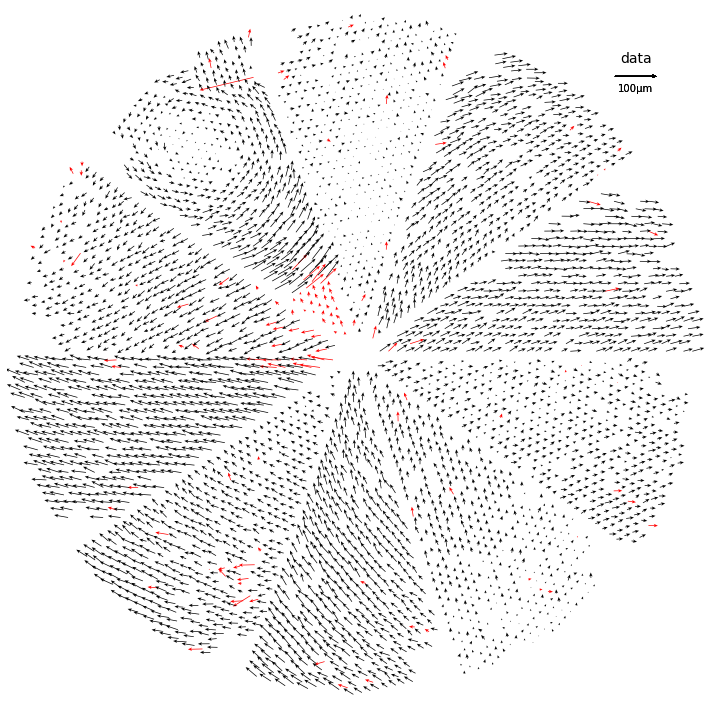

In [386]:
plot_fit(fit_results, fit_params, 'data', save='fit-data.png')

The 5-parameter petal-misalignment model first rotates each petal about a fitted center point (3 params), then offsets it by a constant amount (2 params). Plot just the best-fit rotation first, with the fitted rotation centers shown as blue points:

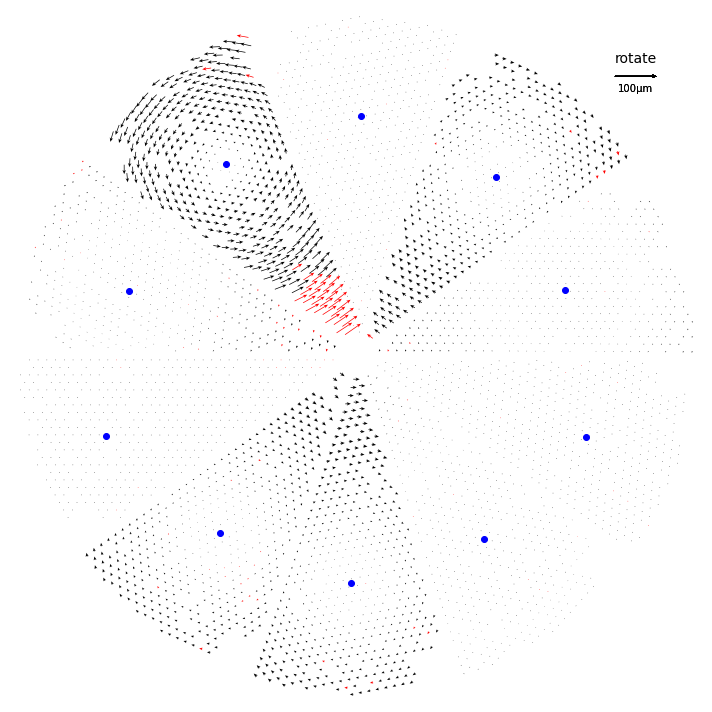

In [387]:
plot_fit(fit_results, fit_params, 'rotate', True, save='fit-rotate.png')

Next, show just the best-fit constant offsets per petal:

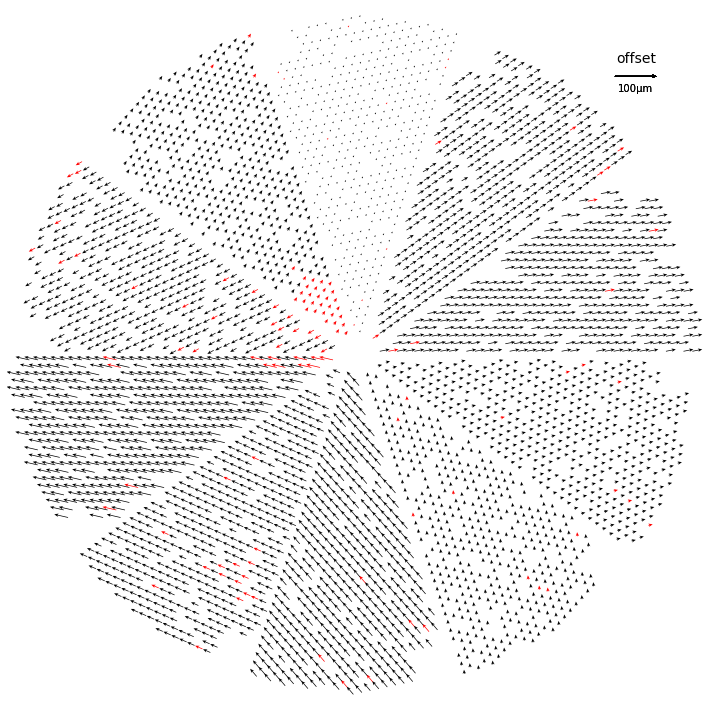

In [388]:
plot_fit(fit_results, fit_params, 'offset', save='fit-offset.png')

Finally, show the combined rotate & offset best-fit model:

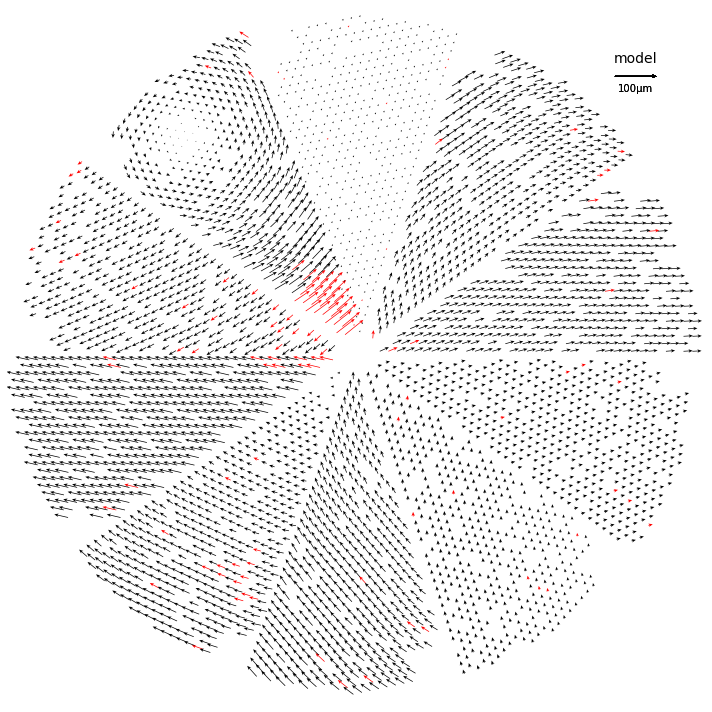

In [389]:
plot_fit(fit_results, fit_params, 'model', save='fit-model.png')

and the resulting fit residuals, which are used to identify and ignore the outliers shown in red. Note the larger arrow scale (25 vs 100um):

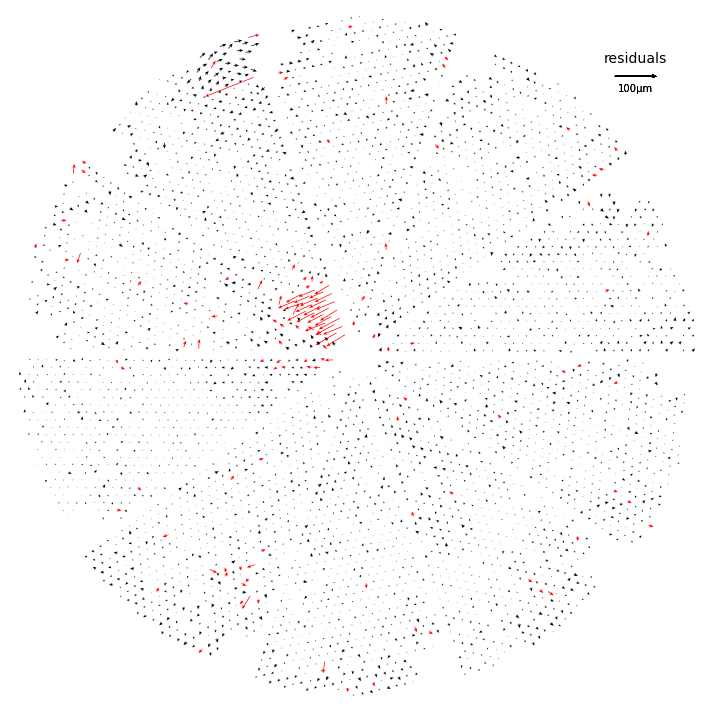

In [390]:
plot_fit(fit_results, fit_params, 'residuals', ref=100, save='fit-residuals.png')

Identify robots with large residuals after subtracting the 5-parameter best fits:

In [34]:
def list_outliers(A=fit_results, n=10, petals=range(10)):
    
    petals = np.atleast_1d(petals)
    resid_dr = np.hypot(A.resid_dx, A.resid_dy)
    isort = np.argsort(resid_dr)[::-1]
    for idx in isort:
        row = A.iloc[idx]
        loc = A.index[idx]
        if loc // 1000 not in petals:
            continue
        print(f'{loc2pos[loc]} loc={loc} resid=({row.resid_dx:.2f},{row.resid_dy:.2f})um core={row.core}')
        n -= 1
        if n == 0:
            break

List the 10 largest outliers over the whole focal plane (`core=False` corresponds to the red arrows above):

In [35]:
list_outliers()

M05886 loc=6333 resid=(-116.65,-46.47)um core=False
M06041 loc=6002 resid=(-50.92,-29.57)um core=False
M06047 loc=6003 resid=(-50.47,-26.88)um core=False
M08333 loc=6007 resid=(-49.66,-20.06)um core=False
M06039 loc=6000 resid=(-45.15,-27.94)um core=False
M05711 loc=6004 resid=(-45.18,-25.35)um core=False
M06037 loc=6001 resid=(-46.80,-19.55)um core=False
M06169 loc=6020 resid=(-44.79,-23.50)um core=False
M05717 loc=6009 resid=(-43.70,-23.07)um core=False
M05715 loc=6015 resid=(-43.11,-22.93)um core=False


Identify robots in P9 that are likely affected by the C3 divot:

In [36]:
list_outliers(petals=9)

M02113 loc=9349 resid=(-19.80,-31.72)um core=False
M07913 loc=9271 resid=(-18.70,-6.38)um core=False
M01556 loc=9323 resid=(17.12,-8.33)um core=False
M07442 loc=9279 resid=(-13.82,-6.07)um core=False
M02121 loc=9127 resid=(8.26,11.24)um core=True
M01752 loc=9524 resid=(-9.36,-9.81)um core=True
M07754 loc=9327 resid=(11.70,-5.61)um core=True
M01950 loc=9083 resid=(12.02,3.79)um core=True
M07908 loc=9236 resid=(11.71,3.91)um core=True
M07497 loc=9305 resid=(3.50,-11.61)um core=True


Partition the space explored by each fiber into a 2D grid of cells, and assign each move to a cell based on its requested (x,y):

In [37]:
def addbin(M, nbins=15, rmax=6):

    bins = np.linspace(-rmax, +rmax, nbins+1)
    xbin = np.digitize(M.req_x, bins)
    ybin = np.digitize(M.req_y, bins)
    M['bin'] = (nbins + 2) * ybin + xbin
    
addbin(All)

Extract binned or unbinned data (x,y,dx,dy) for a single robot:

**Extract binned counts and estimate uncertainties on each binned (dx,dy) for fitting**

In [286]:
def get_data(pos_id, M=All, fit_results=fit_results, outlier_nsig=4, subtract='fit',
             binned=True, min_count=16, summary='mean', sig2d=10, verbose=True):
    
    # Restrict to the selected robot
    loc = pos2loc[pos_id]
    sel = (M.location == loc)
    M = M[sel]
    # Extract the unbinned values.
    x, y = M.req_x, M.req_y
    dx, dy = M.dx, M.dy
    # Subtract the median or fit if requested
    info = fit_results.loc[loc]
    if subtract == 'median':
        dx -= info.dx
        dy -= info.dy
    elif subtract == 'fit':
        dx -= info.fit_dx
        dy -= info.fit_dy
    # Reject residual outliers.
    dr = np.hypot(dx, dy)
    core = ~get_outliers(dr, outlier_nsig)
    if verbose:
        print(f'Ignoring {np.count_nonzero(~core)} / {len(core)} outlier moves')
    x, y = x[core], y[core]
    dx, dy = dx[core], dy[core]
    if binned:
        # Only use bins with at least min_count moves.
        counts = np.bincount(M.bin[core])
        good_bin = np.where(counts >= min_count)
        rejected = np.count_nonzero((counts > 0) & (counts < min_count))
        if verbose:
            print(f'Ignoring {rejected} bins with <{min_count} non-outlier moves')
        M = M[np.isin(M.bin, good_bin) & core]
        bybin = M.groupby(by='bin').agg({
            'location': 'sum', 'req_x': 'mean', 'req_y': 'mean', 'dx': summary, 'dy': summary})
        x, y = bybin.req_x, bybin.req_y
        dx, dy = bybin.dx, bybin.dy
        n = np.array(bybin.location)
        #assert np.all(n >= min_count)
        wgt = n / sig2d ** 2
    else:
        wgt = np.ones(len(x)) / sig2d ** 2

    # Rotate to undo the nominal petal alignment.
    petal_loc = loc // 1000
    phi = (petal_loc - 3) * np.pi / 5
    C, S = np.cos(phi), np.sin(phi)
    x, y = C * x + S * y, -S * x + C * y
    dx, dy = C * dx + S * dy, -S * dx + C * dy
    
    # Correct for ds/dr in the radial direction.
    # ...

    return np.asarray(x), np.asarray(y), np.asarray(dx), np.asarray(dy), wgt

Fit (x,y,dx,dy) for a single robot to a model of calibration errors (dx0,dy0,dr1,dr2):

**How to handle (x,y) that are not reachable for (r1,r2)?**

In [216]:
def xy2tp(x, y, r1, r2, x0, y0):
    r12 = r1 + r2
    r1sq = r1 ** 2
    r2sq = r2 ** 2
    phi = np.arctan2(y - y0, x - x0)
    rsq = (x - x0) ** 2 +  (y - y0) ** 2
    r = np.sqrt(rsq)
    s = (rsq - r2sq + r1sq) / (2 * (r + 1e-9))
    beta = np.arccos(s / r1)
    #a = np.sqrt(r1sq - s * s)
    #beta = np.arctan2(a, s)
    T = phi - beta
    P = np.arccos((rsq - r1sq - r2sq) / (2 * r1 * r2))
    return T, P

In [50]:
def tp2xp(T, P, r1, r2, x0, y0):
    x = x0 + r1 * np.cos(T) + r2 * np.cos(T + P)
    y = y0 + r1 * np.sin(T) + r2 * np.sin(T + P)
    return x, y

In [276]:
def calib_errors_model(x, y, dx0, dy0, dr1, dr2, r1, r2):
    # Calculate angles using the assumed calibration parameters.
    T, P = xy2tp(x, y, r1, r2, 0., 0.,)
    # Calculate actual positions for the specified calibration errors in microns.
    x2, y2 = tp2xp(T, P, r1 + 1e-3 * dr1, r2 + 1e-3 * dr2, 1e-3 * dx0, 1e-3 * dy0)
    # Return residuals in microns
    return 1e3 * (x2 - x), 1e3 * (y2 - y)

In [277]:
def fit_calib_errors(pos_id, x, y, dx, dy, wgt):

    loc = pos2loc[pos_id]
    r1, r2, _ = r12s_by_loc[loc]
    
    def fun(params):
        dx0, dy0, dr1, dr2 = params
        dx_pred, dy_pred = calib_errors_model(x, y, dx0, dy0, dr1, dr2, r1, r2)
        nll = 0.5 * np.sum(wgt * ((dx_pred - dx) ** 2 + (dy_pred - dy) ** 2))
        # Add Gaussian priors
        nlp = 0.5 * (np.hypot(dx0, dy0) - 100) ** 2 + 0.5 * (np.hypot(dr1, dr2) - 25) ** 2
        return nll + nlp

    wsum = wgt.sum()
    dx0 = np.sum(wgt * dx) / wsum
    dy0 = np.sum(wgt * dy) / wsum    
    initial = [dx0, dy0, 0., 0.]
    if len(x) >= 5:
        fit = scipy.optimize.minimize(fun, initial, method='Nelder-Mead') #, options=dict(maxiter=2000))
        del fit['final_simplex']
    else:
        fit = dict(x=initial, success=False, fun=0., message='Not enough data')
    fit['r1'] = r1
    fit['r2'] = r2

    return fit

In [280]:
import desimeter.transform.zhaoburge

In [349]:
def fit_zhaoburge(x, y, dx, dy, wgt, polids=[0,1,2,3,4,5,6,9,20,27,28,29,30]):
    # 0  = S2 = translation along X
    # 1  = S3 = translation along Y
    # 2  = S4 = magnification
    # 27 = T4 = rotation
    ndata = len(x)
    nzb = len(polids)
    H = np.zeros((2 * ndata, nzb))
    for i, polid in enumerate(polids):
        zbx, zby, _ = desimeter.transform.zhaoburge.getZhaoBurgeTerm(polid, x, y)
        H[:ndata, i] = zbx
        H[ndata:, i] = zby
    
    # Solve a weighted linear least squares problem, instead of the unweighted method used in
    # desimeter.transform.zhaoburge.fitZhaoBurge
    W = np.diag(np.concatenate([wgt, wgt]))
    HT = np.transpose(H)
    A = HT.dot(W.dot(H))
    b = HT.dot(W.dot(np.concatenate([dx, dy])))
    #coefs = np.linalg.solve(A, b)
    try:
        coefs, residuals, rank, s = np.linalg.lstsq(A, b, rcond=None)
    except numpy.linalg.LinAlgError:
        print('Fit failed')
        return -1., 1.
    
    fit_dx, fit_dy = H.dot(coefs).reshape((2, ndata))
    #fit_dx1, fit_dy1 = desimeter.transform.zhaoburge.getZhaoBurgeXY(polids, coefs, x, y)
    #assert np.allclose(fit_dx, fit_dx1)
    #assert np.allclose(fit_dy, fit_dy1)

    return fit_dx, fit_dy

In [294]:
pos_id = 'M06939'
x, y, dx, dy, wgt = get_data(pos_id)
fit_calib_errors(pos_id, x, y, dx, dy, wgt)

Ignoring 21 / 5027 outlier moves
Ignoring 37 bins with <16 non-outlier moves


     fun: 6985118.32375001
 message: 'Optimization terminated successfully.'
    nfev: 500
     nit: 303
      r1: 3.0508
      r2: 3.0392
  status: 0
 success: True
       x: array([-6.76209957, -1.31887893,  7.88242948, -1.44930003])

In [345]:
fit_zhaoburge(x, y, dx, dy, wgt);

Plot all moves for a single robot. The two main options are:
 - binned: show residuals for all moves or the median residuals for binned moves (with at least min_count moves per bin)
 - subtract: show raw residuals or subtract the median or best-fit residual

In [350]:
def plot_one(pos_id, 
             M=All, fit_results=fit_results, outlier_nsig=4, subtract='fit', binned=True, min_count=16, summary='mean',
             what='data,model', ref=100, rmax=6, size=7.5, fit_model='zhaoburge', save=None):

    loc = pos2loc[pos_id]
    x, y, dx, dy, wgt = get_data(pos_id, M, fit_results, outlier_nsig, subtract, binned, min_count, summary)
    
    fit = None
    what = what.split(',')
    if binned and ('model' in what or 'residual' in what):
        if fit_model == 'calib_errors':
            fit = fit_one(pos_id, x, y, dx, dy, wgt)
            if fit['success']:
                print(f'chisq / dof = {fit.fun / len(x):.2f}  params {np.round(fit.x, 3)}')
                fit_dx, fit_dy = distortion_model(x, y, *fit['x'], fit['r1'], fit['r2'])
            else:
                print('Fit failed:', fit['message'])
                return
        elif fit_model == 'zhaoburge':
            fit_dx, fit_dy = fit_zhaoburge(x, y, dx, dy, wgt)
        else:
            print(f'Invalid fit_model "{fit_model}".')
            return
    else:
        what = ('data',)

    fig, ax = plt.subplots(1, 1, figsize=(size, size))
    width = 0.002 if binned else 0.001
    Q = None
    if 'model' in what:
        Q = ax.quiver(x, y, fit_dx, fit_dy, angles='xy', scale=ref / 1., scale_units='xy',
                      headwidth=5, headlength=6, color='r', width=width)
    if 'residual' in what:
        Q = ax.quiver(x, y, dx - fit_dx, dy - fit_dy, angles='xy', scale=ref / 1., scale_units='xy',
                      headwidth=5, headlength=6, color='b', width=width)
    if 'data' in what:
        norm = matplotlib.colors.Normalize(vmin=0., vmax=np.percentile(wgt, 95))
        Q = ax.quiver(x, y, dx, dy, wgt, norm=norm, angles='xy', scale=ref / 1., scale_units='xy',
                      headwidth=5, headlength=6, cmap='gray_r', width=width)
    ax.quiverkey(Q, X=0.90, Y=0.95, U=ref, label=f'{ref}μm', labelpos='S')
    ax.set(xlim=(-rmax,rmax), ylim=(-rmax,rmax), aspect=1,
           xlabel='Petal Δx [mm]', ylabel='Petal Δy [mm]')
    ax.text(0.02, 0.95, f'{pos_id}', fontsize=12, transform=ax.transAxes)
    ax.text(0.02, 0.90, f'loc {loc}', fontsize=12, transform=ax.transAxes)
    if fit_model == 'calib_errors':
        r1, r2, _ = r12s_by_loc[loc]
        dx0, dy0, dr1, dr2 = fit['x']
        ax.text(0.02, 0.06, f'Δx0 = {dx0:.1f}μm', fontsize=12, transform=ax.transAxes)
        ax.text(0.02, 0.02, f'Δy0 = {dy0:.1f}μm', fontsize=12, transform=ax.transAxes)
        ax.text(0.98, 0.06, f'r1 = {1e3*r1:.0f}{dr1:+.0f}μm', fontsize=12, transform=ax.transAxes, ha='right')
        ax.text(0.98, 0.02, f'r2 = {1e3*r2:.0f}{dr2:+.0f}μm', fontsize=12, transform=ax.transAxes, ha='right')

    ax.plot(0, 0, 'b+', ms=20)
    ax.add_artist(plt.Circle((0, 0), rmax, fc='none', ec='b', lw=1, ls='--'))
    plt.tight_layout()
    if save:
        plt.savefig()

Look at a random "good" robot:

Ignoring 44 / 5039 outlier moves


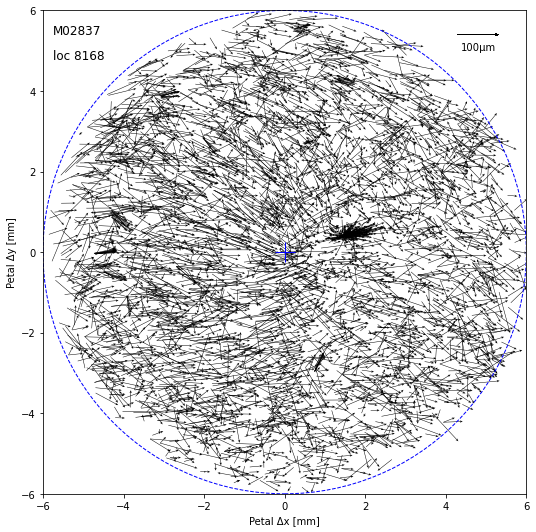

In [357]:
plot_one('M02837', binned=False, subtract='none')

Ignoring 105 / 5039 outlier moves


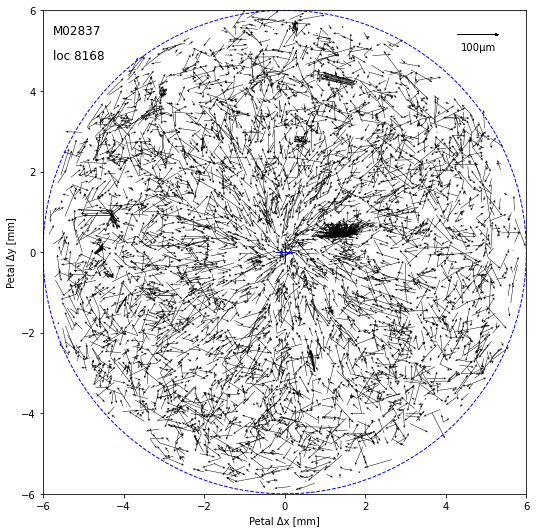

In [360]:
plot_one('M02837', binned=False, subtract='fit')

Ignoring 105 / 5039 outlier moves
Ignoring 40 bins with <16 non-outlier moves


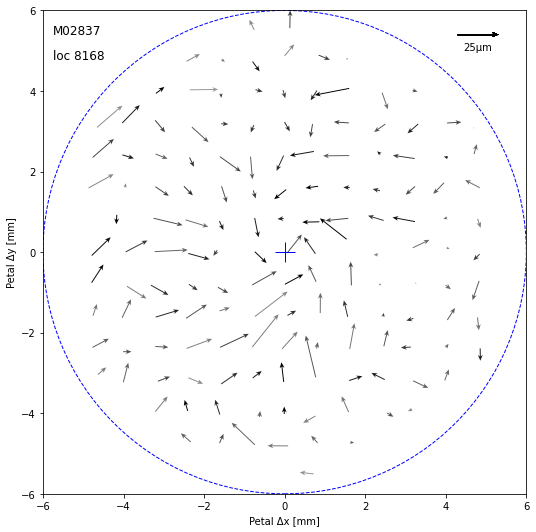

In [364]:
plot_one('M02837', binned=True, subtract='fit', what='data', ref=25)

Ignoring 21 / 5027 outlier moves
Ignoring 37 bins with <16 non-outlier moves


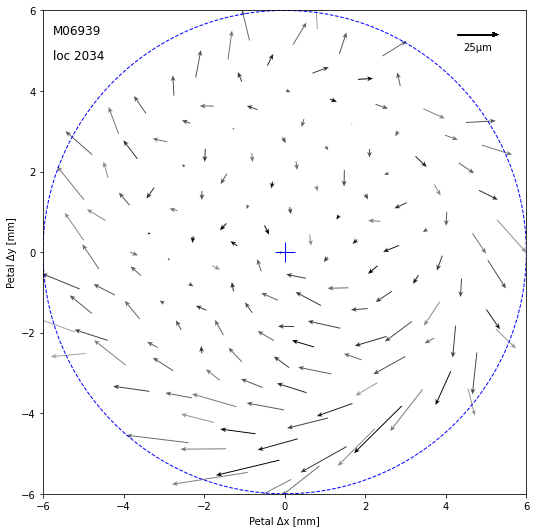

In [378]:
plot_one('M06939', binned=True, what='data', ref=25)

Ignoring 21 / 5027 outlier moves
Ignoring 37 bins with <16 non-outlier moves
chisq / dof = 45654.37  params [-6.762 -1.319  7.882 -1.449]


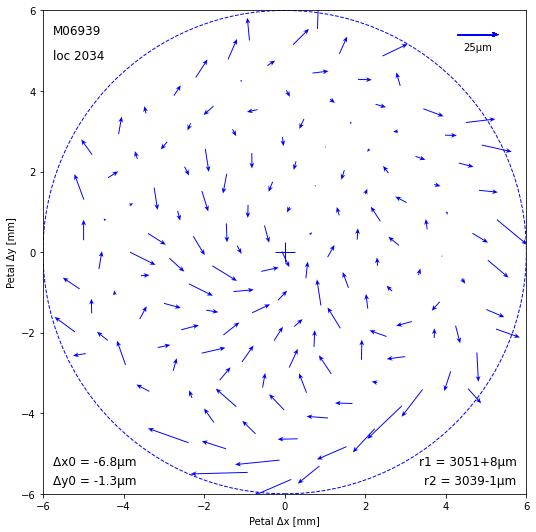

In [377]:
plot_one('M06939', binned=True, what='residual', ref=25, fit_model='calib_errors')

Ignoring 21 / 5027 outlier moves
Ignoring 37 bins with <16 non-outlier moves
chisq / dof = 45654.37  params [-6.762 -1.319  7.882 -1.449]


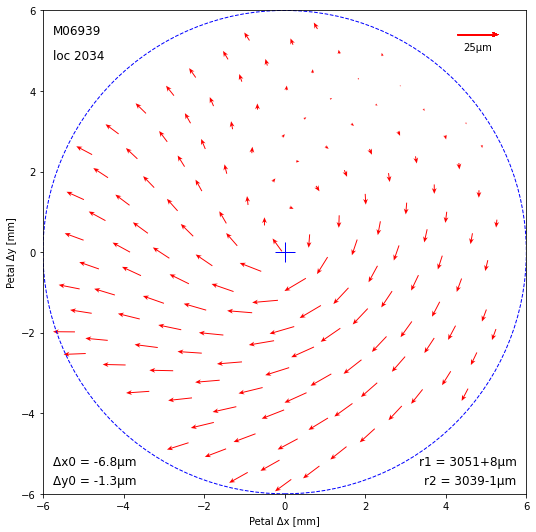

In [381]:
plot_one('M06939', binned=True, what='model', ref=25, fit_model='calib_errors')

Ignoring 21 / 5027 outlier moves
Ignoring 37 bins with <16 non-outlier moves


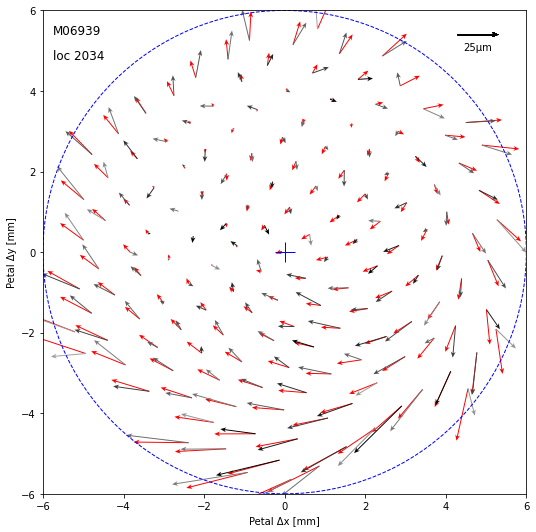

In [380]:
plot_one('M06939', binned=True, what='data,model', ref=25, fit_model='zhaoburge')

Ignoring 21 / 5027 outlier moves
Ignoring 37 bins with <16 non-outlier moves


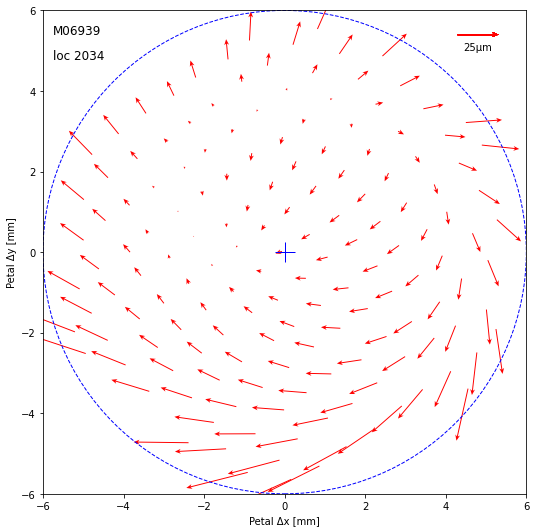

In [351]:
plot_one('M06939', binned=True, ref=25, what='model')

Ignoring 21 / 5027 outlier moves
Ignoring 37 bins with <16 non-outlier moves


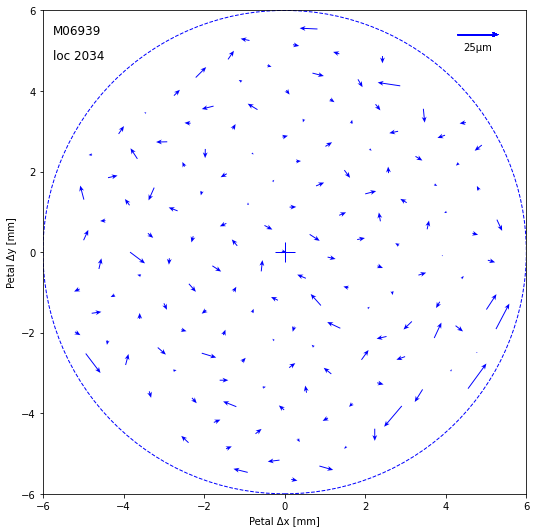

In [348]:
plot_one('M06939', binned=True, ref=25, what='residual')

Loop over and fit all robots:

In [352]:
def fit_all(M=All, fit_results=fit_results):
    
    results = { }
    for loc in sorted(M.location.unique()):
        pos_id = loc2pos[loc]
        x, y, dx, dy, wgt = get_data(pos_id, verbose=False)
        fit_dx, fit_dy = fit_zhaoburge(x, y, dx, dy, wgt)
        data_dr = np.hypot(dx, dy)
        residual_dr = np.hypot(dx - fit_dx, dy - fit_dy)
        dr1 = np.median(data_dr)
        dr2 = np.median(residual_dr)
        #print(f'{loc} {pos_id} {dr1:.1f} {dr2:.1f}')
        results[pos_id] = [dr1, dr2]
        
    return results

In [353]:
%time results = fit_all()

/Users/dkirkby/miniforge3/envs/desi/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/dkirkby/miniforge3/envs/desi/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


CPU times: user 5min 5s, sys: 3min, total: 8min 6s
Wall time: 1min 33s


In [261]:
import json

In [265]:
class NumpyEncoder(json.JSONEncoder):
    """JSON encoder to use with numpy data with rounding of float32 values.
    """
    FLOAT32_DECIMALS = 6
    def default(self, obj):
        if isinstance(obj, np.float32):
            # Convert to 64-bit float before rounding.
            return float(np.round(np.float64(obj), self.FLOAT32_DECIMALS))
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.ndarray):
            if obj.dtype.fields is not None:
                # convert a recarray to a dictionary.
                new_obj = {}
                for (name, (dtype, size)) in obj.dtype.fields.items():
                    if dtype.base == np.float32:
                        new_obj[name] = np.round(obj[name], self.FLOAT32_DECIMALS)
                    else:
                        new_obj[name] = obj[name]
                return new_obj
            else:
                if obj.dtype == np.float32:
                    # tolist converts to 64-bit native float so apply rounding first.
                    obj = np.round(obj.astype(np.float64), self.FLOAT32_DECIMALS)
                return obj.tolist()
        else:
            return super().default(obj)

In [266]:
with open('fits.json', 'w') as f:
    json.dump(results, f, cls=NumpyEncoder)